# AddTracking Fraud Detection: Exploratory Data Analysis

In [147]:
import numpy as np         # linear algebra
import sklearn as sk       # machine learning
import pandas as pd        # reading in data files, data cleaning
import matplotlib.pyplot as plt   # for plotting
import seaborn as sns      # visualization tool
import tensorflow as tf
import keras
import pickle



In [148]:
data = pd.read_csv("data/train.csv", nrows=round(10e6))

In [149]:
sns.set(rc={'figure.figsize':(12,6)});
plt.figure(figsize=(12,6));

<Figure size 864x432 with 0 Axes>

In [150]:
data.head(10)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0
5,18787,3,1,16,379,2017-11-06 14:36:26,NaN,0
6,103022,3,1,23,379,2017-11-06 14:37:44,NaN,0
7,114221,3,1,19,379,2017-11-06 14:37:59,NaN,0
8,165970,3,1,13,379,2017-11-06 14:38:10,NaN,0
9,74544,64,1,22,459,2017-11-06 14:38:23,NaN,0


In [151]:
# Let's see the data types for all our data
data.dtypes

ip                  int64
app                 int64
device              int64
os                  int64
channel             int64
click_time         object
attributed_time    object
is_attributed       int64
dtype: object

We can see that most off the 'id' types are integer data types when really they should be categorical.  
Changing them to categorical will let pandas give us statistics such as `unique, top, freq`

In [152]:
features = ["ip","app","device","os","channel","is_attributed"]
for feature in features:
    data[feature] = data[feature].astype("category")

data.dtypes


ip                 category
app                category
device             category
os                 category
channel            category
click_time           object
attributed_time      object
is_attributed      category
dtype: object

In [ ]:
# Let's convert the click_time field into a timestamp object that Pandas knows how to manipulate (i.e order)
# Then pandas will give us stastics such as "first" and "last" click_time values 
data["click_time"] = pd.to_datetime(data['click_time'])
data["attributed_time"] = pd.to_datetime(data['attributed_time'])


In [154]:
data.describe()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
count,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000,18717,10000000.0
unique,68740.0,332.0,940.0,292.0,170.0,29943,15698,2.0
top,73516.0,12.0,1.0,19.0,245.0,2017-11-06 16:05:10,2017-11-06 23:36:23,0.0
freq,51711.0,1291185.0,9381146.0,2410148.0,793105.0,1261,6,9981283.0
first,NaN,NaN,NaN,NaN,NaN,2017-11-06 14:32:21,2017-11-06 16:00:47,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-11-07 00:12:03,2017-11-07 15:59:53,NaN


Let's look at the distribution of '1's and '0's for is_attributed column

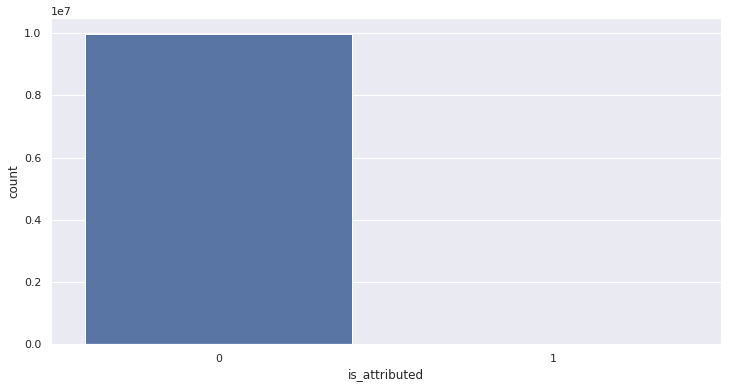

In [163]:
class_counts = data.groupby('is_attributed').size()
sns.set(style="darkgrid")
ax = sns.countplot(x="is_attributed", data=data)

We can see that fraudalent clicks are more than 99% of all clicks. 

### Analysis

`click_time`: Our 10 million clicks were obtained on 2017, December 6th to December 7th.  So the following data spans around 9 hours.  

`attributed_time`: Wow, so it looks like there are only 18717 non-null values for `attributed_time`. Which means only 18717 values have `1` for `is_attributed` and the rest clicks are `0` 

`ip`: If there are only 68740 unique IP addresses out of 10 million clicks.  Also, the IP with the most clicks had over 50,000 clicks!  Either that IP was a bot or IP addresses are network IP's rather than device level IPs
 


In [164]:
# Let's count the number of clicks with `1` as `is_attributed` to verify that it is only 18717
data[data["is_attributed"]==1]['is_attributed'].count()

18717

So we were correct, there are only 18,717 clicks that are attributed (non fraudalent) the rest are all fraudalent

In [165]:
# Converting features back to numerical data
mdata = data.copy(deep=True)
features = ["ip","app","device","os","channel","is_attributed"]
for feature in features:
    mdata[feature] = mdata[feature].astype("int64")


### Click Count and Conversation Rate for Apps

Conversation Rate is defined as the % of click counts that resulted in a download

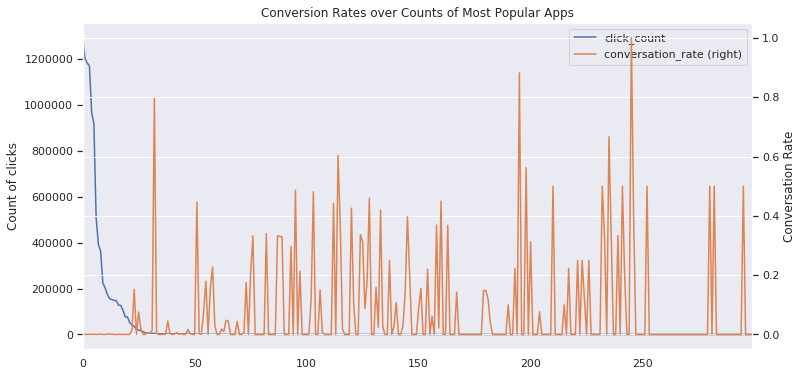

Counversion Rates over Counts of Most Popular APPs


,app,click_count,conversation_rate
0,12,1291185,0.000140
1,2,1202534,0.000388
2,15,1181585,0.000277
3,3,1170412,0.000630
4,9,966839,0.000869
5,18,917820,0.000397
6,14,507491,0.000483
7,1,391508,0.000350
8,8,364361,0.001441
9,21,223823,0.000089


In [167]:
# grouping by mean produces the conversation rate because values are 1 and 0
conversation_rate = mdata[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = mdata[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(conversation_rate, on='app', how='left')
merge.columns = ['app', 'click_count', 'conversation_rate']

ax = merge[:300].plot(y=["click_count","conversation_rate"],secondary_y='conversation_rate')
plt.title('Conversion Rates over Counts of Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Conversation Rate')
plt.show()

print('Counversion Rates over Counts of Most Popular APPs')
merge.head(10)



The reason why the conversation rate is so low for the most frequent clicks agrees with the general distribution of 99% clicks being fraudalent.  The conversation_rate line fluctuates for less common apps because there are not a lot of click_counts for them so variability is very high.

### Click Count and Conversation Rate for IP
(Note: the same code for the above graph can be more or less copied)

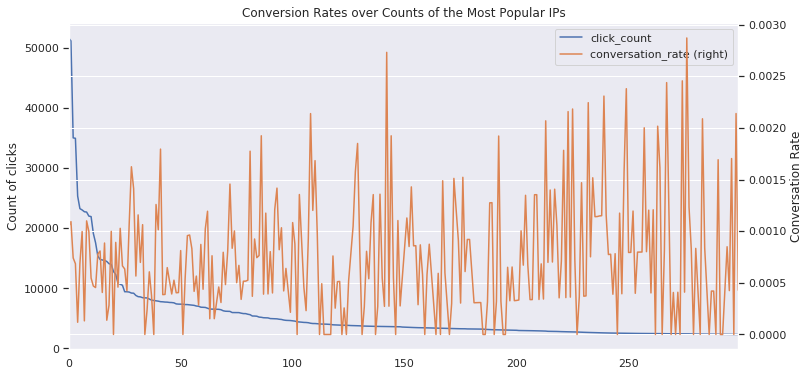

Counversion Rates over Counts of Most Popular IPs


,ip,click_count,conversation_rate
0,73516,51711,0.001044
1,73487,51215,0.001093
2,5314,35073,0.000741
3,5348,35004,0.000686
4,53454,25381,0.000118
5,105560,23289,0.000687
6,100275,23070,0.000997
7,114276,22774,0.000132
8,201182,22719,0.001100
9,105475,22047,0.000998


In [168]:
conversation_rate = mdata[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = mdata[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(conversation_rate, on='ip', how='left')
merge.columns = ['ip', 'click_count', 'conversation_rate']

ax = merge[:300].plot(y=["click_count","conversation_rate"],secondary_y='conversation_rate')
plt.title('Conversion Rates over Counts of the Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Conversation Rate')
plt.show()

print('Counversion Rates over Counts of Most Popular IPs')
merge.head(10)



Not really any patterns can be seen between ip and click_count and conversation_rate

### Click Count and Conversation Rate for Device
(Note: the same code for the above graph can be more or less copied)

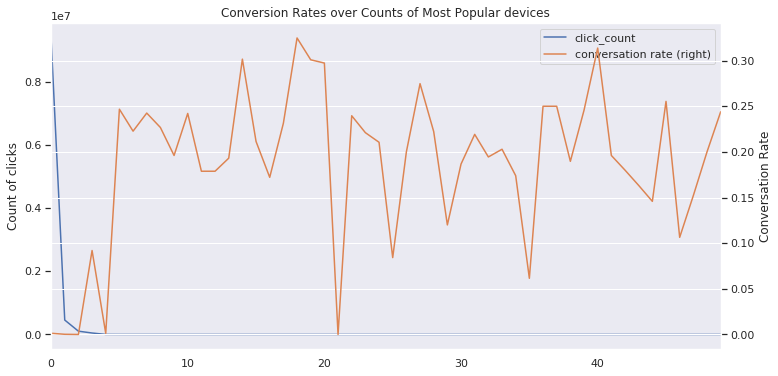

Counversion Rates over Counts of Most Popular devices


,device,click_count,conversation rate
0,1,9381146,0.001326
1,2,456617,0.000208
2,3032,104393,0.000000
3,0,46476,0.091961
4,59,1618,0.001236
5,40,462,0.246753
6,6,458,0.222707
7,16,334,0.242515
8,18,247,0.226721
9,33,204,0.196078


In [169]:
conversation_rate = mdata[['device', 'is_attributed']].groupby('device', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = mdata[['device', 'is_attributed']].groupby('device', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(conversation_rate, on='device', how='left')
merge.columns = ['device', 'click_count', 'conversation rate']

ax = merge[:50].plot(y=["click_count","conversation rate"],secondary_y='conversation rate')
plt.title('Conversion Rates over Counts of Most Popular devices')
ax.set(ylabel='Count of clicks')
plt.ylabel('Conversation Rate')
plt.show()

print('Counversion Rates over Counts of Most Popular devices')
merge.head(10)



Some interesting observations to be made here. It seems that the device `1` holds over 70% of all click counts made.  Probably a common android device or i-phone in the region this data was collected.

But like the other graphs, there weren't any patterns between the device and conversation rate. (For the devices with very little click counts, the conversation rates are high because there was little amounts of click counts which results in high variability)

## Experementing with the Random Forest Model

In [170]:
# Feature engineering for click time

s_sec = data['click_time'].dt.second
m_sec = data['click_time'].dt.minute*60
hr_sec = data['click_time'].dt.hour*3600

data['click_time_secs'] = s_sec + m_sec + hr_sec

In [171]:

X = data[['app', 'device', 'os', 'channel', 'click_time_secs']]
y = data['is_attributed']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [172]:
from sklearn.ensemble import RandomForestClassifier
RandomForest = RandomForestClassifier()
RandomForest.fit(X_train,y_train)
rf_score = RandomForest.score(X_test,y_test)
print("Random Forest accuracy:", rf_score)

/root/.local/share/virtualenvs/fraud_detection-yH1T5P0u/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest accuracy: 0.997782


In [173]:
# Saving Model
model = RandomForest
model_file = "RF.sav"
with open(model_file,'wb') as out:
    pickle.dump(model, out)


In [174]:
# Testing loading Model
with open(model_file, 'rb') as inp:
    model = pickle.load(inp)
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [175]:
rf_score = RandomForest.score(X_test,y_test)
rf_score

0.997782

We got over 99% accuracy on our validation set!!! However, it turns out that this model is overfitting teribly on the test set.  In the kaggle given training sets, 99% of clicks are `0` for is_attribute.  However in the kaggle test set, we figured out that is_attribute values are evenly split between `1` and `0`.

This unbalance between the training and test sets explains the overfitting. 

Thus we decided to create an `equalized_training` set with even distrubution of is_attribute values.  